In [27]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import xarray as xr

# Function to create non-overlapping chunks of missing data
def create_gap_chunks(n_points, ngaps, chunk_size):
    gap_starts = np.sort(np.random.choice(n_points - chunk_size, ngaps, replace=False))
    gap_indices = np.concatenate([np.arange(start, start + chunk_size) for start in gap_starts])
    return gap_indices

## Try GPR with two buoys

In [10]:
# Generate synthetic data for two semi-correlated buoy stations
np.random.seed(42)
n_points = 100
ngaps = 5  # Number of chunks
chunk_size = n_points // 10  # Each chunk is about 10% of the data

time = np.linspace(0, 10, n_points)  # Regular time points for both buoys

# Generate interannual variability: low-frequency sinusoidal component
interannual_variability = 1.5 * np.sin(2 * np.pi * time / 5)  # Period of 5 units (simulating years)

# Generate baseline temperatures around 20°C for Buoy 1
baseline_temp1 = 20 + 5 * np.exp(-10 * time)  # Slowly decaying baseline

# Add interannual variability to baseline temperature for Buoy 1
temperature1 = baseline_temp1 + interannual_variability + np.random.normal(0, 1, n_points)

# Generate Buoy 2's temperature, similar to Buoy 1 but with slight variations
temperature2 = temperature1 + np.random.normal(0, 1, n_points)  # Small random perturbation for Buoy 2

# Introduce chunks of missing data in Buoy 1 and Buoy 2, but at different times
gap_indices1 = create_gap_chunks(n_points, ngaps, chunk_size)  # Gaps for Buoy 1
gap_indices2 = create_gap_chunks(n_points, ngaps, chunk_size)  # Gaps for Buoy 2 (non-overlapping)

temperature1_with_missing = temperature1.copy()
temperature2_with_missing = temperature2.copy()

temperature1_with_missing[gap_indices1] = np.nan  # Set Buoy 1 gaps
temperature2_with_missing[gap_indices2] = np.nan  # Set Buoy 2 gaps

# Combine lon, lat, and time for GPR (including shared spatial information)
lon1, lat1 = -70, 42  # Buoy 1 location
lon2, lat2 = -70.2, 42.1  # Buoy 2 location
coords1 = np.column_stack([np.full(n_points, lon1), np.full(n_points, lat1), time])
coords2 = np.column_stack([np.full(n_points, lon2), np.full(n_points, lat2), time])

# Combine both buoys' coordinates and temperatures for shared GPR model
all_coords = np.vstack([coords1, coords2])  # Spatial-temporal coordinates for both buoys
all_temperature = np.concatenate([temperature1_with_missing, temperature2_with_missing])

# Filter out NaN values (missing data) for GPR
valid_indices = ~np.isnan(all_temperature)
valid_coords = all_coords[valid_indices]
valid_temperature = all_temperature[valid_indices]

# ---- Gaussian Process Regression (shared GPR model) ----
# Define kernel for GPy (RBF kernel + bias)
kernel = GPy.kern.RBF(input_dim=3, lengthscale=1.0, variance=1.0) + GPy.kern.Bias(input_dim=3)

# Create and optimize GPR model using both buoys' data
gpr_model = GPy.models.GPRegression(valid_coords, valid_temperature[:, None], kernel)
gpr_model.optimize()

K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])


# Predict temperature values using GPR for the full time series for both buoys
gpr_pred_full, gpr_var_full = gpr_model.predict(all_coords)

# Split the predictions back into Buoy 1 and Buoy 2
gpr_pred1_full = gpr_pred_full[:n_points].flatten()
gpr_pred2_full = gpr_pred_full[n_points:].flatten()

# ---- Fill in the gaps in the original data for plotting ----
temperature1_filled_gpr = gpr_pred1_full  # Flattened GPR predictions for Buoy 1
temperature2_filled_gpr = gpr_pred2_full  # Flattened GPR predictions for Buoy 2

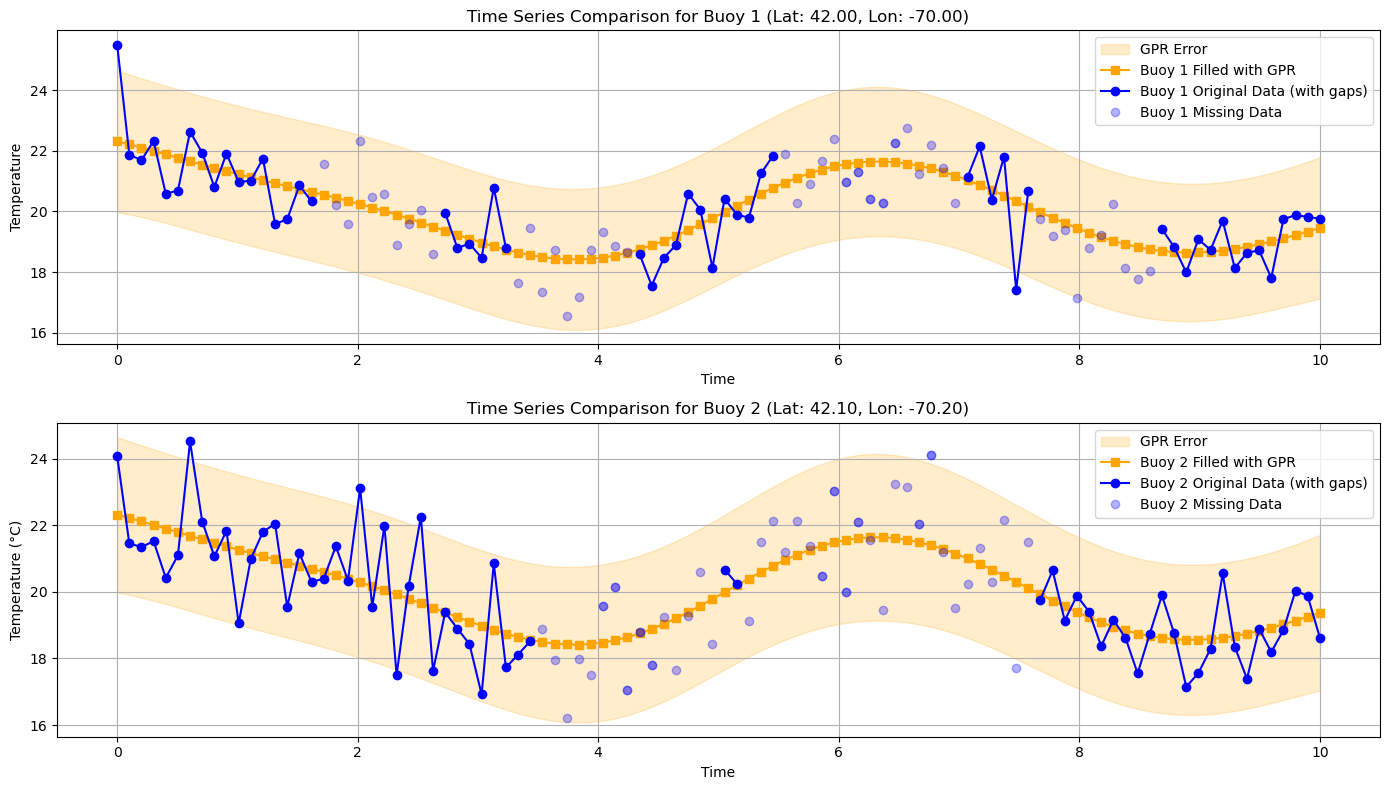

In [15]:
# ---- Plot the Before and After Time Series with Error Bars ----
plt.figure(figsize=(14, 8))

# Plot Buoy 1 with GPR and Kriging error bands for the entire time series
plt.subplot(2, 1, 1)
plt.fill_between(time, temperature1_filled_gpr.flatten() - 2 * np.sqrt(gpr_var_full[:n_points].flatten()), temperature1_filled_gpr.flatten() + 2 * np.sqrt(gpr_var_full[:n_points].flatten()), color='orange', alpha=0.2, label='GPR Error')
plt.plot(time, temperature1_filled_gpr, 's-', label='Buoy 1 Filled with GPR', color='orange')
plt.plot(time, temperature1_with_missing, 'o-', label='Buoy 1 Original Data (with gaps)', color='blue', zorder=10)  # Plot original last
plt.plot(time[gap_indices1], temperature1[gap_indices1], 'o', color='blue', alpha = 0.3, label='Buoy 1 Missing Data')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title(f'Time Series Comparison for Buoy 1 (Lat: {lat1:.2f}, Lon: {lon1:.2f})')
plt.legend()
plt.grid(True)

# Plot Buoy 2 with GPR and Kriging error bands for the entire time series
plt.subplot(2, 1, 2)
plt.fill_between(time, temperature2_filled_gpr.flatten() - 2 * np.sqrt(gpr_var_full[n_points:].flatten()), temperature2_filled_gpr.flatten() + 2 * np.sqrt(gpr_var_full[n_points:].flatten()), color='orange', alpha=0.2, label='GPR Error')
plt.plot(time, temperature2_filled_gpr, 's-', label='Buoy 2 Filled with GPR', color='orange')
plt.plot(time, temperature2_with_missing, 'o-', label='Buoy 2 Original Data (with gaps)', color='blue', zorder=10)  # Plot original
plt.plot(time[gap_indices2], temperature2[gap_indices2], 'o', color='blue', alpha = 0.3, label='Buoy 2 Missing Data')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Time Series Comparison for Buoy 2 (Lat: {lat2:.2f}, Lon: {lon2:.2f})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Now try GPR with ten buoys and xarray!

In [25]:
# Create synthetic xarray dataset with (space, time) dimensions
n_space = 10  # Number of spatial points (buoys)
n_time = 100  # Number of time points

time = np.linspace(0, 10, n_time)
space = np.arange(n_space)

# Define random lat/lon positions for the buoys (latitude: 40-45N, longitude: 70-75W)
latitudes = 40 + 5 * np.random.rand(n_space)
longitudes = -75 + 5 * np.random.rand(n_space)

# Generate synthetic temperature data for each spatial point with interannual variability
interannual_variability = 1.5 * np.sin(2 * np.pi * time / 5)
baseline_temperature = 20 + 5 * np.exp(-10 * time)

# Randomly varying the baseline temperatures for each spatial location
temperature_data = np.array([baseline_temperature + interannual_variability * _ + np.random.normal(0, 0.2, n_time) 
                             for _ in range(n_space)])

ngaps = 5  # Number of chunks
chunk_size = n_time // 10

# Create gaps in temperature data
for i in range(n_space):
    gap_indices = create_gap_chunks(n_time, ngaps, chunk_size)
    temperature_data[i, gap_indices] = np.nan

# Create xarray Dataset
ds = xr.Dataset(
    {
        'temperature': (['space', 'time'], temperature_data)
    },
    coords={
        'space': space,
        'time': time,
        'lat': ('space', latitudes),
        'lon': ('space', longitudes)
    }
)

# Prepare data for GPR
temperature_flat = ds['temperature'].stack(z=('space', 'time')).values  # Flatten space-time dimensions
valid_indices = ~np.isnan(temperature_flat)

# Create 2D spatial coordinates (lat/lon) + time for GPR
coords_flat = np.array([[ds['lat'].values[s], ds['lon'].values[s], t] for s in ds['space'].values for t in ds['time'].values])

# Filter out valid (non-NaN) temperature values and coordinates
valid_coords = coords_flat[valid_indices]
valid_temperature = temperature_flat[valid_indices]

# ---- Gaussian Process Regression (GPR) ----
# Define GPR kernel (RBF for space + time)
kernel = GPy.kern.RBF(input_dim=3, lengthscale=1.0, variance=1.0) + GPy.kern.Bias(input_dim=3)

# GPR model using the valid (non-missing) data
gpr_model = GPy.models.GPRegression(valid_coords, valid_temperature[:, None], kernel)
gpr_model.optimize()

# Predict the temperature for the entire dataset
gpr_pred, gpr_var = gpr_model.predict(coords_flat)

# Reshape the predictions back into the original dataset shape (space, time)
pred_temperature = gpr_pred.reshape(n_space, n_time)
var_temperature = gpr_var.reshape(n_space, n_time)

# Add the GPR-predicted values into the xarray dataset
ds['temperature_filled_gpr'] = (['space', 'time'], pred_temperature)
ds['gpr_variance'] = (['space', 'time'], var_temperature)

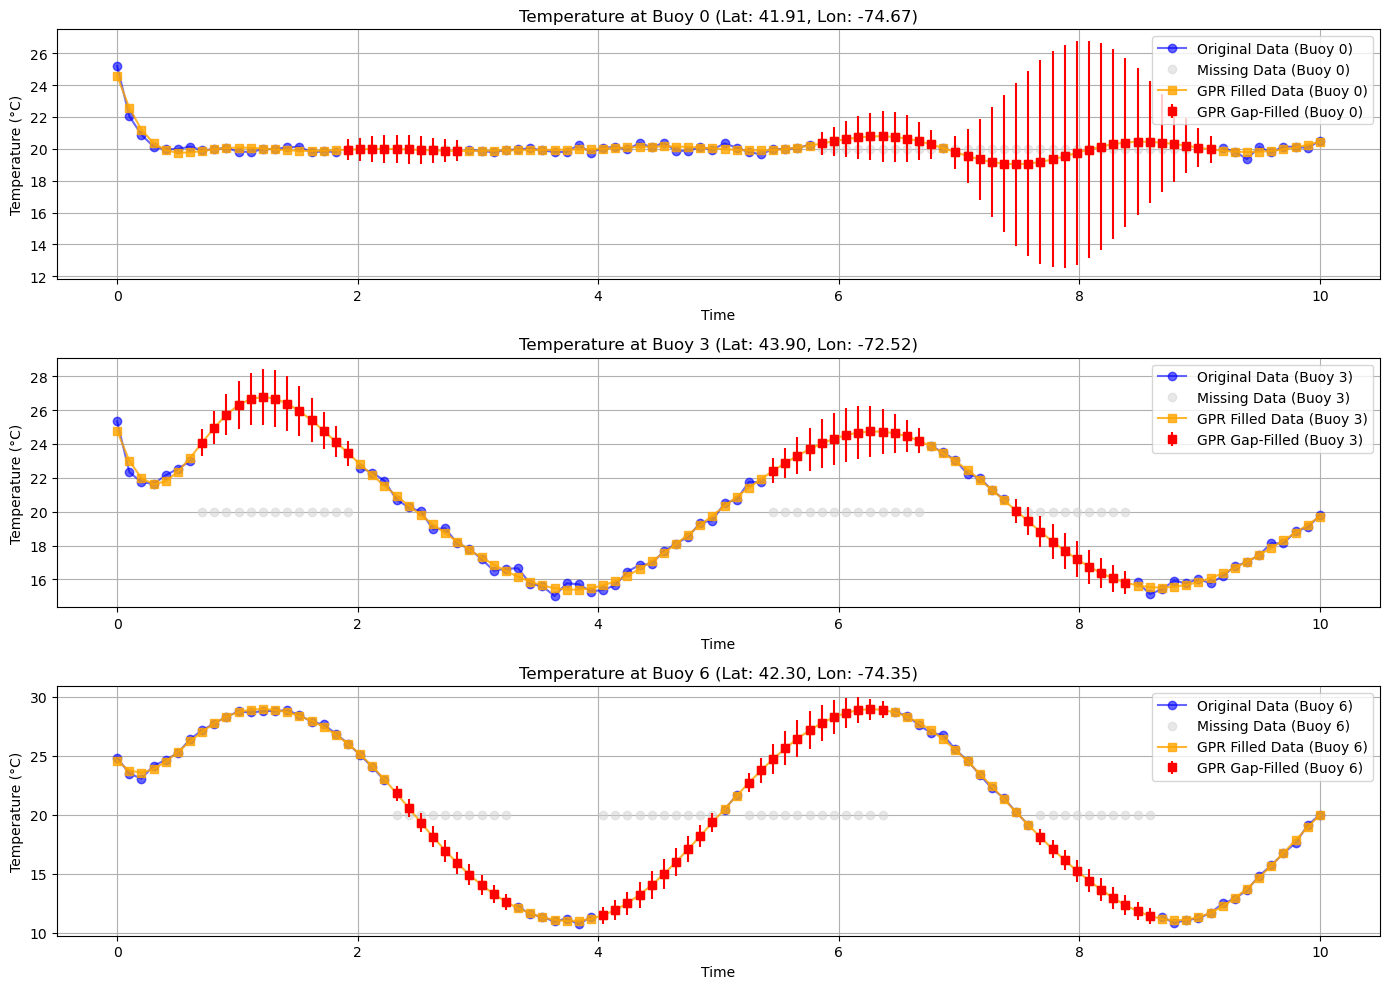

In [26]:
# ---- Plot the Before and After GPR Time Series for a Few Spatial Points ----
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

for i, ax in enumerate(axs):
    space_point = i * (n_space // 3)  # Select 3 space points to visualize

    time = ds['time'].values
    temp_original = ds['temperature'].isel(space=space_point).values
    temp_filled = ds['temperature_filled_gpr'].isel(space=space_point).values
    temp_var = ds['gpr_variance'].isel(space=space_point).values

    gap_indices = np.where(np.isnan(temp_original))[0]

    # Plot original data with missing points
    ax.plot(time, temp_original, 'o-', label=f'Original Data (Buoy {space_point})', color='blue', alpha=0.6)
    
    # Plot the missing data in a lighter color
    ax.plot(time[gap_indices], np.full_like(gap_indices, np.nanmean(temp_filled)), 'o', color='lightgray', label=f'Missing Data (Buoy {space_point})', alpha=0.5)
    
    # Plot GPR-filled data
    ax.plot(time, temp_filled, 's-', label=f'GPR Filled Data (Buoy {space_point})', color='orange', alpha=0.8)
    
    # Plot error bars for the filled data at gap indices
    ax.errorbar(time[gap_indices], temp_filled[gap_indices], yerr=2*np.sqrt(temp_var[gap_indices]), fmt='s', color='red', label=f'GPR Gap-Filled (Buoy {space_point})')

    ax.set_title(f'Temperature at Buoy {space_point} (Lat: {ds["lat"].values[space_point]:.2f}, Lon: {ds["lon"].values[space_point]:.2f})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
